### Notes:

* python script stores result of the simulation in a predetermined location
* jupyter notebook shows visualizations of the results from solidity implementation and cadCAD model and error metrics

In [1]:
from pathlib import Path
import os
import csv
import sys
import datetime as dt
import json
from enum import Enum
import pandas as pd
import numpy as np
%matplotlib inline

sys.path.append('./models')

path = Path().resolve()
root_path = str(path).split('notebooks')[0]
os.chdir(root_path)

In [2]:
with open('./tests/data/historic_market_prices.csv', newline='') as f:
    reader = csv.reader(f)
    market_prices = list(reader)[0]
    market_prices = [float(price) for price in market_prices]

In [10]:
#python stores a file containing Kp, Ki and a time series of market prices 
#(an array of tuples, or two arrays, containing a timestamp and the price, 
#or the time elapsed and the price change - we can go with whatever is easier to implement on the JS side)

#instead of file name being hardcoded, we could have it stored in an environment 
#variable that both python and JS read from
Kp = 7.5e-8
Ki = 2.23e-14

# no leak
#per_second_leak = 1000000000000000000000000000
per_second_leak = 999999711200000000000000000
control_period = 3600

length = len(market_prices)
delta_t = [control_period] * length
SIMULATION_TIMESTEPS = length - 1

# Raw error
#save_dir = "../truffle/test/saved_sims/pi_second/raw/custom-config-sim.txt"

# Scaled(percent) error
save_dir = "../truffle/test/saved_sims/pi_second/scaled/custom-config-sim.txt"

config_file = {
  "Kp": str(int(Kp * 1e18)),
  "Ki": str(int(Ki * 1e18)),
  "noise_barrier": "1000000000000000000",
  "per_second_leak": str(int(per_second_leak)),
  "oracle_initial_price": "2000000000000000000",
  "initial_redemption_price": "2000000000000000000000000000",
  "delta_t": [str(i) for i in delta_t],
  "market_prices": [str(int(i*1e18)) for i in market_prices],
  "save_dir": save_dir
}

# Raw Error
#with open('./cross-model/truffle/test/config/pi_second_raw.json', 'w') as fp:

# Scaled(percent) error
with open('./cross-model/truffle/test/config/pi_second_scaled.json', 'w') as fp:
    json.dump(config_file, fp)
    
config_file = {
  "alpha": per_second_leak,
  "kp": Kp,
  "ki": lambda control_period=control_period: Ki,
  "delta_t": delta_t,
  "market_prices": market_prices,
  #'error_term': lambda target, measured: target - measured # Raw error
  'error_term': lambda target, measured: (target - measured)/target # Scaled(percent) error
}

In [4]:
market_prices[0:5]

[2.03520968321892,
 2.00675297061406,
 2.02594470965992,
 2.05147525236802,
 1.94445601467646]

In [5]:
# Compile, test, and deploy contracts to Ganache
# !npm run pi-raw-second-imported-config --prefix './cross-model/truffle'

os.chdir('./cross-model/truffle')
!npm run install-deps
#!npm run pi-raw-second-imported-config # raw
!npm run pi-scaled-second-imported-config # scaled
os.chdir('../../')


> geb-rrfm-truffle-sims@1.0.0 install-deps
> npm install

m#########⠂⠂⠂⠂⠂⠂⠂⠂⠂⸩ ⠙ idealTree: timing idealTree Completed in 16ms
up to date, audited 3 packages in 714ms

found 0 vulnerabilities

> geb-rrfm-truffle-sims@1.0.0 pi-scaled-second-imported-config
> npx truffle test test/pi_scaled_second_imported_config.js


Compiling your contracts...
> Compiling ./cross-model/truffle/contracts/Migrations.sol
> Compiling ./cross-model/truffle/contracts/calculator/math/SafeMath.sol
> Compiling ./cross-model/truffle/contracts/calculator/math/SignedSafeMath.sol
> Compiling ./cross-model/truffle/contracts/calculator/per-second/raw/PIRawPerSecondValidator.sol
> Compiling ./cross-model/truffle/contracts/calculator/per-second/scaled/PIScaledPerSecondValidator.sol
> Compiling ./cross-model/truffle/contracts/mock/AGUpdater.sol
> Compiling ./cross-model/truffle/contracts/mock/MockOracleRelayer.sol
> Compiling ./cross-model/truffle/contracts/mock/MockTreasury.sol
> Compiling ./cross-model/truffle/contra

[redemptionRate](https://github.com/reflexer-labs/geb-rrfm-truffle-sims/blob/master/contracts/mock/MockOracleRelayer.sol#L14) = $1+d_t$ (units: per second)  
$p_{t+\Delta{t}} = p_{t} (1+d_t)^{\Delta{t}}$ where $\Delta{t}$ is measured in seconds  
Meaning:
* $d_t > 0$ implies $redemptionRate > 1$  
* $d_t < 0$ implies $redemptionRate < 1$  


In the results dataset this is the PerSecondRedemptionRate column

In [11]:
from models.system_model_v1.model.state_variables.init import state_variables

def pre_process_initial_conditions(genesis_dict):
    base_genesis_states = genesis_dict.copy()
    for k in base_genesis_states.keys():
        if k in config_file:
            try:
                base_genesis_states[k] = config_file[k][0]
            except:
                base_genesis_states[k] = config_file[k]
    return base_genesis_states

test_specific_initial_conditions = pre_process_initial_conditions(state_variables)

In [12]:
from models.system_model_v1.model.params.init import params


def pre_process_params_dict(params_dict):
    base_params_dict = params_dict.copy()
    for k in config_file.keys():
        if type(config_file[k]) == list:
            base_params_dict[k] = [config_file[k]]
        else:
            try:
                base_params_dict[k] = [config_file[k]]
            except OverflowError:
                print(config_file[k])
                raise
    return base_params_dict

test_specific_params = pre_process_params_dict(params)

In [13]:
def test_specific_resolve_time_passed(params, substep, state_history, state):
    index = state['timestep']+1
    value = params['delta_t'][index]
    return {'seconds_passed': value}

def test_specific_update_market_price(params, substep, state_history, state, policy_input):
    key = 'market_price'  
    index = state['timestep']
    value = params['market_prices'][index]
    return key, value


from models.system_model_v1.model.parts.markets import resolve_time_passed, update_market_price
from models.system_model_v1.model.partial_state_update_blocks import partial_state_update_blocks

for psub in partial_state_update_blocks:
    for psub_part in psub.values():
        if type(psub_part)==dict:
            for k,v in psub_part.items():
                if v == resolve_time_passed:
                    psub_part[k] = test_specific_resolve_time_passed
                if v == update_market_price:
                    psub_part[k] = test_specific_update_market_price

In [14]:
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD import configs

del configs[:]

exp = Experiment()

sim_config_dict = {
    'T': range(SIMULATION_TIMESTEPS),
    'N': 1,
    'M': test_specific_params
}
c = config_sim(sim_config_dict)

exp.append_configs(
    initial_state=test_specific_initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=c #preprocessed dictionaries containing simulation parameters
)

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
exec_mode = ExecutionMode()
local_mode_ctx = ExecutionContext(exec_mode.local_mode)
executor = Executor(local_mode_ctx, configs) # Pass the configuration object inside an array
raw_result, tensor, sessions = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (651, 24, 1, 15)



Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded



Total execution time: 0.21s


In [15]:
full = pd.DataFrame(raw_result)

In [16]:
max_substep = max(full.substep)
df = full.copy()
df = df[(df.substep==max_substep) | (df.substep==0)]

In [17]:
# Raw
#save_dir = "./cross-model/truffle/test/saved_sims/pi_second/raw/custom-config-sim.txt"

# Scaled
save_dir = "./cross-model/truffle/test/saved_sims/pi_second/scaled/custom-config-sim.txt"

data = pd.read_csv(save_dir, sep=" ", header=None, skiprows=1)
data.columns = [x.replace(' ','') for x in pd.read_csv(save_dir, sep="|", nrows=1).columns]

for c in data.columns:
    data[c]=data[c].apply(float)
#define normalizing constants
WAD = 10**18
RAY = 10**27
RAD = 10**45
#normalize data to "USD" dimension
data['MarketPrice(USD)'] = data['MarketPrice(WAD)']/WAD
data['RedemptionPrice(USD)'] = data['RedemptionPrice(RAY)']/RAY
data['PerSecondRedemptionRate(float)'] = data['PerSecondRedemptionRate(RAY)']/RAY - 1
data['time'] = data['DelaySinceLastUpdate'].cumsum()
data['timestamp'] = state_variables['timestamp'] + data['time'].apply(lambda x: dt.timedelta(seconds=x))

In [18]:
df

,error_star,error_hat,old_error_star,old_error_hat,error_star_integral,error_hat_integral,error_star_derivative,error_hat_derivative,target_rate,target_price,market_price,debt_price,timedelta,timestamp,blockheight,simulation,subset,run,substep,timestep
0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,2.000000,2.000000,2.000000,0,2018-12-18 00:00:00,0,0,0,1,0,0
6,0.000000,0.000061,0.0,0.0,0.000000,0.110489,0.000000e+00,0.000000e+00,0.000000e+00,2.000000,2.006753,2.000061,3600,2018-12-18 01:00:00,240,0,0,1,6,1
12,-0.003376,-0.006947,0.0,0.0,-6.077674,-12.283023,-9.379126e-07,-9.379126e-07,-2.533719e-10,1.999998,2.025945,1.999806,3600,2018-12-18 02:00:00,480,0,0,1,6,2
18,-0.012973,-0.026170,0.0,0.0,-35.429575,-71.893671,-2.665776e-06,-2.665776e-06,-9.737860e-10,1.999991,2.051475,1.999774,3600,2018-12-18 03:00:00,720,0,0,1,6,3
24,-0.025742,-0.050450,0.0,0.0,-104.687786,-209.810008,-3.546911e-06,-3.546911e-06,-1.932996e-09,1.999977,1.944456,2.001025,3600,2018-12-18 04:00:00,960,0,0,1,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3882,-0.011683,-0.057841,0.0,0.0,-75.755135,-30838.043639,5.971404e-06,5.971404e-06,-8.779484e-10,1.999667,2.042810,1.965195,3600,2019-01-13 23:00:00,155280,0,0,1,6,647
3888,-0.021575,-0.077833,0.0,0.0,-134.864983,-31082.255889,-2.747615e-06,-2.747615e-06,-1.621123e-09,1.999655,2.014691,1.964977,3600,2019-01-14 00:00:00,155520,0,0,1,6,648
3894,-0.007519,-0.050536,0.0,0.0,-186.369322,-31313.319576,3.904353e-06,3.904353e-06,-5.680959e-10,1.999651,2.022013,1.964155,3600,2019-01-14 01:00:00,155760,0,0,1,6,649
3900,-0.011183,-0.057798,0.0,0.0,-219.663395,-31508.320620,-1.017636e-06,-1.017636e-06,-8.436001e-10,1.999645,2.027208,1.964215,3600,2019-01-14 02:00:00,156000,0,0,1,6,650


In [19]:
data

,MarketPrice(WAD),RedemptionPrice(RAY),RedemptionRate(%),PerSecondRedemptionRate(RAY),RedemptionRateTimeline(Seconds),Proportional(NoGain),Proportional(WithGain),Integral(NoGain),Integral(WithGain),DelaySinceLastUpdate,MarketPrice(USD),RedemptionPrice(USD),PerSecondRedemptionRate(float),time,timestamp
0,2.035210e+18,2.000000e+27,1.0,1.000000e+27,1.0,-1.760484e+25,-1.320363e+18,0.000000e+00,0.000000e+00,3600.0,2.035210,2,-1.32036e-09,3600.0,2018-12-18 01:00:00
1,2.006753e+18,1.999990e+27,1.0,1.000000e+27,1.0,-3.381255e+24,-2.535941e+17,-3.777497e+28,-8.423819e+14,3600.0,2.006753,1.99999,-2.54436e-10,7200.0,2018-12-18 02:00:00
2,2.025945e+18,1.999989e+27,1.0,1.000000e+27,1.0,-1.297810e+25,-9.733574e+17,-6.719304e+28,-1.498405e+15,3600.0,2.025945,1.99999,-9.74856e-10,10800.0,2018-12-18 03:00:00
3,2.051475e+18,1.999982e+27,1.0,1.000000e+27,1.0,-2.574704e+25,-1.931028e+18,-1.368285e+29,-3.051275e+15,3600.0,2.051475,1.99998,-1.93408e-09,14400.0,2018-12-18 04:00:00
4,1.944456e+18,1.999968e+27,1.0,1.000000e+27,1.0,2.775630e+25,2.081722e+18,-1.330696e+29,-2.967453e+15,3600.0,1.944456,1.99997,2.07875e-09,18000.0,2018-12-18 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,2.042810e+18,1.999640e+27,1.0,1.000000e+27,1.0,-2.158851e+25,-1.619138e+18,-2.407976e+29,-5.369786e+15,3600.0,2.042810,1.99964,-1.62451e-09,2332800.0,2019-01-14 00:00:00
648,2.014691e+18,1.999629e+27,1.0,1.000000e+27,1.0,-7.532666e+24,-5.649499e+17,-2.929655e+29,-6.533130e+15,3600.0,2.014691,1.99963,-5.71483e-10,2336400.0,2019-01-14 01:00:00
649,2.022013e+18,1.999624e+27,1.0,1.000000e+27,1.0,-1.119622e+25,-8.397164e+17,-3.263875e+29,-7.278442e+15,3600.0,2.022013,1.99962,-8.46995e-10,2340000.0,2019-01-14 02:00:00
650,2.027208e+18,1.999618e+27,1.0,1.000000e+27,1.0,-1.379727e+25,-1.034795e+18,-3.710366e+29,-8.274117e+15,3600.0,2.027208,1.99962,-1.04307e-09,2343600.0,2019-01-14 03:00:00


In [20]:
combined = df.merge(data, how='inner', on=['timestamp'])
combined = combined.iloc[25:]
combined

,error_star,error_hat,old_error_star,old_error_hat,error_star_integral,error_hat_integral,error_star_derivative,error_hat_derivative,target_rate,target_price,...,RedemptionRateTimeline(Seconds),Proportional(NoGain),Proportional(WithGain),Integral(NoGain),Integral(WithGain),DelaySinceLastUpdate,MarketPrice(USD),RedemptionPrice(USD),PerSecondRedemptionRate(float),time
25,0.001237,0.008220,0.0,0.0,-1426.885963,-2573.791826,4.373131e-06,4.373131e-06,6.092884e-11,1.999781,...,1.0,1.231783e+24,9.238375e+16,-1.467377e+30,-3.272250e+16,3600.0,1.997307,1.99977,5.96614e-11,93600.0
26,-0.010832,-0.015578,0.0,0.0,-1442.271633,-2587.036434,-3.352401e-06,-3.352401e-06,-8.445624e-10,1.999775,...,1.0,-1.083692e+25,-8.127692e+17,-1.483141e+30,-3.307405e+16,3600.0,2.021442,1.99977,-8.45843e-10,97200.0
27,-0.005809,-0.007638,0.0,0.0,-1469.953159,-2628.825464,1.395375e-06,1.395375e-06,-4.684285e-10,1.999771,...,1.0,-5.813552e+24,-4.360164e+17,-1.511575e+30,-3.370813e+16,3600.0,2.011391,1.99976,-4.69725e-10,100800.0
28,-0.003268,-0.002311,0.0,0.0,-1484.337618,-2646.734041,7.057886e-07,7.057886e-07,-2.781863e-10,1.999769,...,1.0,-3.272705e+24,-2.454529e+17,-1.526360e+30,-3.403782e+16,3600.0,2.006306,1.99976,-2.79491e-10,104400.0
29,0.010778,0.026654,0.0,0.0,-1468.481321,-2602.915926,3.901665e-06,3.901665e-06,7.756167e-10,1.999775,...,1.0,1.077335e+25,8.080013e+17,-1.511273e+30,-3.370138e+16,3600.0,1.978215,1.99976,7.743e-10,108000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,-0.011683,-0.057841,0.0,0.0,-75.755135,-30838.043639,5.971404e-06,5.971404e-06,-8.779484e-10,1.999667,...,1.0,-1.169695e+25,-8.772715e+17,-1.810719e+29,-4.037903e+15,3600.0,2.023036,1.99965,-8.81309e-10,2329200.0
647,-0.021575,-0.077833,0.0,0.0,-134.864983,-31082.255889,-2.747615e-06,-2.747615e-06,-1.621123e-09,1.999655,...,1.0,-2.158851e+25,-1.619138e+18,-2.407976e+29,-5.369786e+15,3600.0,2.042810,1.99964,-1.62451e-09,2332800.0
648,-0.007519,-0.050536,0.0,0.0,-186.369322,-31313.319576,3.904353e-06,3.904353e-06,-5.680959e-10,1.999651,...,1.0,-7.532666e+24,-5.649499e+17,-2.929655e+29,-6.533130e+15,3600.0,2.014691,1.99963,-5.71483e-10,2336400.0
649,-0.011183,-0.057798,0.0,0.0,-219.663395,-31508.320620,-1.017636e-06,-1.017636e-06,-8.436001e-10,1.999645,...,1.0,-1.119622e+25,-8.397164e+17,-3.263875e+29,-7.278442e+15,3600.0,2.022013,1.99962,-8.46995e-10,2340000.0


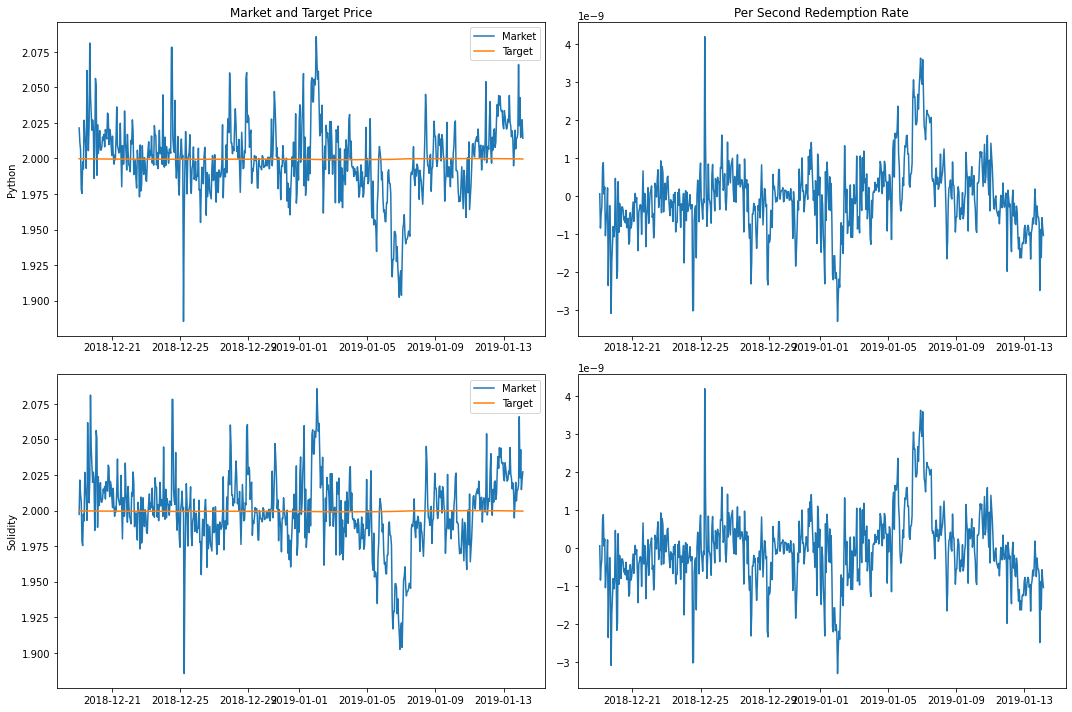

In [21]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(15,10))

i = 0
axs.flat[i].plot(combined['timestamp'], combined['market_price'], label='Market')
axs.flat[i].plot(combined['timestamp'], combined['target_price'], label='Target')
axs.flat[i].set_ylabel('Python')
axs.flat[i].set_title('Market and Target Price')
axs.flat[i].legend()

i += 1 
axs.flat[i].plot(combined['timestamp'], combined['target_rate'])
axs.flat[i].set_title('Per Second Redemption Rate')

i += 1 
axs.flat[i].plot(combined['timestamp'], combined['MarketPrice(USD)'], label='Market')
axs.flat[i].plot(combined['timestamp'], combined['RedemptionPrice(USD)'], label='Target')
axs.flat[i].legend()
axs.flat[i].set_ylabel('Solidity')

i += 1 
axs.flat[i].plot(combined['timestamp'], combined['PerSecondRedemptionRate(float)'])

fig.tight_layout()
plt.show()
fig.savefig('plots/solidity-cadcad/solidity-cadcad-market.png')

<AxesSubplot:>

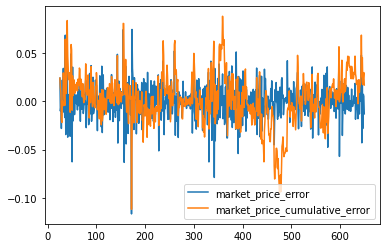

In [22]:
combined['market_price_error'] = combined['market_price'] - combined['MarketPrice(USD)']
combined['market_price_error'].plot(legend=True)
combined['market_price_cumulative_error'] = combined['market_price_error'].cumsum()
combined['market_price_cumulative_error'].plot(legend=True)

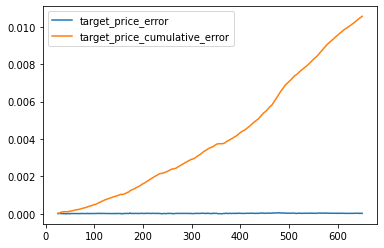

In [23]:
combined['target_price_error'] = combined['target_price'] - combined['RedemptionPrice(USD)']
combined['target_price_error'].plot(legend=True)
combined['target_price_cumulative_error'] = combined['target_price_error'].cumsum()
combined['target_price_cumulative_error'].plot(legend=True)
plt.savefig('plots/solidity-cadcad/solidity-cadcad-error.png')

In [24]:
print(f'''
Max error: {combined['target_price_error'].max()}
Std. error: {combined['target_price_error'].std()}
Mean error: {combined['target_price_error'].mean()}
Abs. mean error: {combined['target_price_error'].abs().mean()}
''')


Max error: 4.7502155921863576e-05
Std. error: 9.366272513054924e-06
Mean error: 1.6877381601125727e-05
Abs. mean error: 1.710082673164331e-05



In [25]:
combined['target_price_cumulative_error'].describe()

count     626.000000
unique    626.000000
top         0.010249
freq        1.000000
Name: target_price_cumulative_error, dtype: float64